In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import os

import anndata
import scanpy as sc
%matplotlib inline

plt.style.use('default')
plt.rc('font', family='Helvetica')
plt.rcParams['pdf.fonttype'] = 42

## RNA preprocess

In [62]:
adata = sc.read_10x_h5('/home/tiankang/tanglei/submit/processed/Fig.1/filtered_feature_bc_matrix.h5' )## from 10X cellranger output
adata.var["mm10"] = adata.var_names.str.startswith("GRCm39")
adata.var["hg38"] = adata.var_names.str.startswith("GRCh38")

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mm10"], percent_top=None, log1p=False, inplace=True
)
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["hg38"], percent_top=None, log1p=False, inplace=True
)

adata.var_names_make_unique()
species = pd.read_csv('/home/tiankang/tanglei/submit/processed/Fig.1/gem_classification.csv', sep=',', index_col=0) ## from 10X cellranger out/analysis file
adata.obs['species'] = species.loc[adata.obs_names, 'call']
# adata.write('/home/tiankang/tanglei/submit/processed/Fig.1/rna_raw.h5ad', compression='gzip')

## CellID preprocess

In [4]:
in_path = '/home/tiankang/tanglei/submit/processed/Fig.1/'

In [ ]:
adata = sc.read_h5ad('/home/tiankang/tanglei/submit/processed/Fig.1/rna_raw.h5ad') ## output from cellranger

## Match 10X RNA and CellID barcode, from 10X website
ref = pd.read_csv('/home/tiankang/tanglei/submit/processed/resource/3M-february-2018.txt.gz', header=None,sep='\t', index_col=0)
ref.columns = ['CellID']

/tmp/ipykernel_173787/2982149744.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Class",


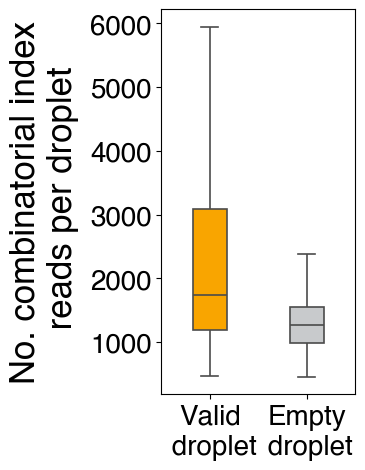

In [6]:
data = pd.read_csv('/home/tiankang/tanglei/submit/processed/Fig.1/processed.txt', sep='\t', header=None)  ## processed.txt generated from 01.preprocess.sh
data.columns = ['Barcode','UMI','CellID']
data.drop_duplicates(subset=['Barcode','UMI'], inplace=True)

bcs = adata.obs_names
bcs = np.array([item.split('-')[0] for item in bcs])
bcs = ref.loc[bcs,'CellID'].values

signal = data[data.Barcode.isin(bcs)]
noise = data[~data.Barcode.isin(bcs)]

signal_counts = signal.groupby('Barcode')['CellID'].agg(lambda x:x.count()).to_frame()
noise_counts = noise.groupby('Barcode')['CellID'].agg(lambda x:x.count()).to_frame()

out = pd.DataFrame({'CellID':list(signal_counts['CellID']) + list(noise_counts['CellID']),
                    'Class':["Valid\n droplet"]*len(signal_counts)+['Empty\n droplet']*len(noise_counts)})
# out.to_csv(in_path + 'nCellID.txt', sep='\t')

plt.figure(figsize=(2.5,5))
sns.boxplot(x="Class", 
            y="CellID", 
            data=out, 
            linewidth=1.2, 
            fliersize=0.8, 
            width=0.35,
            showfliers=False, 
            saturation=1,
            palette=['#f9a500', '#c8cacc'])

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('No. combinatorial index\n reads per droplet',fontsize=25,labelpad=8)
plt.xlabel('',fontsize=20,labelpad=8)
plt.title('',fontsize=25, pad=8)
plt.show()

In [7]:
a = out.loc[out.Class=='Valid\n droplet','CellID'].values
b = out.loc[out.Class!='Valid\n droplet','CellID'].values

print('Performing t-test analysis...')
from scipy.stats import ttest_ind
from scipy.stats import levene

stat, p = levene(a,b)

if p < 0.05:
    f, p = ttest_ind(a,b, alternative='greater', equal_var=False)
else:
    f, p = ttest_ind(a,b, alternative='greater', equal_var=True)
    
from pprint import pprint
pprint((ttest_ind(a,b, alternative='greater', equal_var=False)[0],
        ttest_ind(a,b, alternative='greater', equal_var=False)[1]))

Performing t-test analysis...
(41.08811799957815, 0.0)


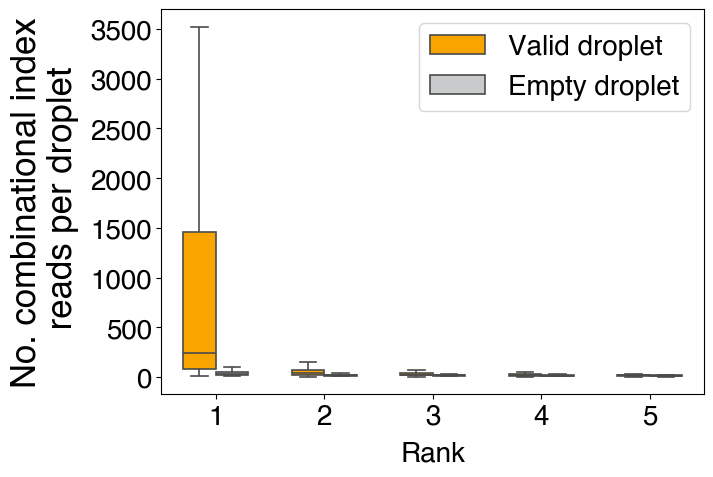

In [12]:
sg = pd.DataFrame(signal.groupby('Barcode')['CellID'].value_counts())
bk = pd.DataFrame(noise.groupby('Barcode')['CellID'].value_counts())

signal_num = sg.groupby('Barcode').apply(lambda x: x.values.squeeze()).to_list()
cells = sg.index.get_level_values('Barcode')
cells = list(dict.fromkeys(cells))
df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in zip(cells, signal_num) ])).T
df.fillna(0, inplace=True)
df = df.astype(int)
df.columns = [str(i+1) for i in range(df.shape[1])]
df_ratio = df.div(df.sum(axis=1), axis='rows')

noise_num = bk.groupby('Barcode').apply(lambda x: x.values.squeeze()).to_list()
noise_barcode = bk.index.get_level_values('Barcode')
noise_barcode = list(dict.fromkeys(noise_barcode))
df_noise = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in zip(noise_barcode, noise_num) ])).T
df_noise.fillna(0, inplace=True)
df_noise = df_noise.astype(int)
df_noise.columns = [str(i+1) for i in range(df_noise.shape[1])]
df_noise_ratio = df_noise.div(df_noise.sum(axis=1), axis='rows')

out = pd.DataFrame({'CellID': list(df.iloc[:,:5].values.reshape(-1,))+list(df_noise.iloc[:,:5].values.reshape(-1,)),
                    'Rank':list(df.columns[:5])*df.shape[0]+list(df_noise.columns[:5])*df_noise.shape[0],
                    'Class':['Valid droplet']*(df.shape[0]*5) + ['Empty droplet']*(df_noise.shape[0]*5)})

# df.to_csv(in_path + 'signal_rank.txt', sep='\t')
# df_noise.to_csv(in_path + 'noise_rank.txt', sep='\t')
# out.to_csv(in_path + 'CellID_rank.txt', sep='\t')

plt.figure(figsize=(7,5))
sns.boxplot(x="Rank", 
            y="CellID", 
            data=out, 
            hue='Class', 
            linewidth=1.2, 
            fliersize=0.8, 
            width=0.6,
            showfliers=False, 
            saturation=1, 
            palette=['#f9a500', '#c8cacc'])

plt.xticks(rotation=0, fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('No. combinational index\nreads per droplet',fontsize=25,labelpad=8)
plt.xlabel('Rank',fontsize=20,labelpad=8)
plt.title('',fontsize=25, pad=8)
plt.legend(loc='best',fontsize=20)

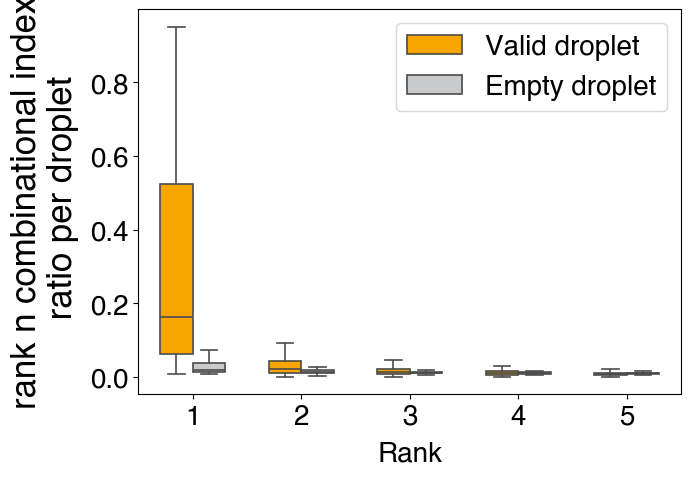

In [25]:
df_ratio = df.div(df.sum(axis=1), axis='rows')
df_noise_ratio = df_noise.div(df_noise.sum(axis=1), axis='rows')

out = pd.DataFrame({'CellID': list(df_ratio.iloc[:,:5].values.reshape(-1,))+list(df_noise_ratio.iloc[:,:5].values.reshape(-1,)),
                    'Rank':list(df_ratio.columns[:5])*df_ratio.shape[0]+list(df_noise_ratio.columns[:5])*df_noise_ratio.shape[0],
                    'Class':['Valid droplet']*(df_ratio.shape[0]*5) + ['Empty droplet']*(df_noise_ratio.shape[0]*5)})

# out.to_csv(in_path + 'CellID_rank_ratio.txt', sep='\t')

plt.figure(figsize=(7,5))
sns.boxplot(x="Rank", 
            y="CellID", 
            data=out, 
            hue='Class', 
            linewidth=1.2, 
            fliersize=0.8, 
            width=0.6,
            showfliers=False, 
            saturation=1, 
            palette=['#f9a500', '#c8cacc'])

plt.xticks(rotation=0, fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('rank n combinational index\nratio per droplet',fontsize=25,labelpad=8)
plt.xlabel('Rank',fontsize=20,labelpad=8)
plt.title('',fontsize=25, pad=8)
plt.legend(loc='best',fontsize=20)

/tmp/ipykernel_173787/1570339093.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['Class'] = 'Valid\ndroplet'
/tmp/ipykernel_173787/1570339093.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp2['Class'] = 'Empty\ndroplet'
/tmp/ipykernel_173787/1570339093.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Class",


Text(0.5, 1.0, '')

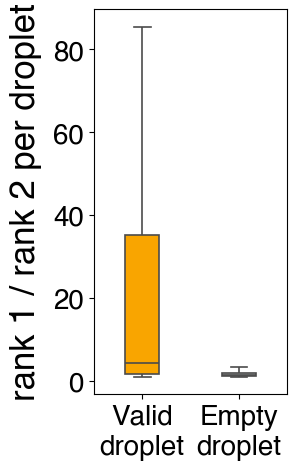

In [156]:
df = pd.read_csv(in_path + 'signal_rank.txt', sep='\t', index_col=0)
df_noise = pd.read_csv(in_path + 'noise_rank.txt', sep='\t', index_col=0)

tmp1 = df.iloc[:,:2]
tmp2 = df_noise.iloc[:,:2]
tmp1['Class'] = 'Valid\ndroplet'
tmp2['Class'] = 'Empty\ndroplet'
out = pd.concat([tmp1, tmp2])
out['CellID'] = out['1']/out['2']

plt.figure(figsize=(2.5,5))
sns.boxplot(x="Class", 
            y="CellID", 
            data=out, 
            linewidth=1.2, 
            fliersize=0.8, 
            width=0.35,
            showfliers=False, 
            saturation=1,
            palette=['#f9a500', '#c8cacc'])

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('rank 1 / rank 2 per droplet',fontsize=25,labelpad=8)
plt.xlabel('',fontsize=20,labelpad=8)
plt.title('',fontsize=25, pad=8)

In [32]:
a = out.loc[out.Class=='Valid\n droplet','CellID'].values
b = out.loc[out.Class!='Valid\n droplet','CellID'].values

print('Performing t-test analysis...')
from scipy.stats import ttest_ind
from scipy.stats import levene

stat, p = levene(a,b)

if p < 0.05:
    f, p = ttest_ind(a,b, alternative='greater', equal_var=False)
else:
    f, p = ttest_ind(a,b, alternative='greater', equal_var=True)
    
from pprint import pprint
pprint((ttest_ind(a,b, alternative='greater', equal_var=False)[0],
        ttest_ind(a,b, alternative='greater', equal_var=False)[1]))

Performing t-test analysis...
(37.820623085383694, 3.773779275096459e-291)


In [51]:
signal_cellid = signal.groupby('Barcode')['CellID'].agg(lambda x:x.value_counts().index[0]).to_frame()
tmp = signal_cellid.copy()

df = pd.read_csv(in_path + 'signal_rank.txt', sep='\t', index_col=0)
df['total'] = df.sum(axis=1)
tmp['total'] = df.loc[tmp.index,'total']
tmp.loc[:,'rank1'] = df.loc[tmp.index, '1']
tmp.loc[:,'rank1_ratio'] = tmp.loc[:,'rank1']/tmp['total']
tmp.loc[:,'rank2'] = df.loc[tmp.index, '2']
tmp.loc[:,'rank2_ratio'] = tmp.loc[:,'rank2']/tmp['total']
# tmp.to_csv(in_path + 'result_without_qc.txt', sep='\t')

## CellID QC

### function

In [1]:
def _plotrank1ratio(df, title=None,save=None):
    tmp = df.copy()
    clump = tmp['CellID'].value_counts().to_frame()
    clump_counts = clump['CellID'].value_counts()

    num = clump_counts.index
    top1_counts, top1_ratio, total_counts, label = [], [], [], []
    for i in num:
        counts = tmp.loc[tmp.CellID.isin(clump[clump['CellID']==i].index),'rank1'].values
        total = tmp.loc[tmp.CellID.isin(clump[clump['CellID']==i].index),'total'].values
        ratio = tmp.loc[tmp.CellID.isin(clump[clump['CellID']==i].index),'rank1_ratio'].values
        total_counts.append(total)
        top1_counts.append(counts)
        top1_ratio.append(ratio)
        label.append([i]*counts.shape[0])

    out = pd.DataFrame({'CellID':np.concatenate(top1_ratio),
                        'Class':np.concatenate(label)})
    plt.figure(figsize=(15,6))
    sns.boxplot(x="Class", y="CellID", data=out, linewidth=1.2, fliersize=0.8, width=0.6,showfliers=False,  saturation=1, palette=['#4692B9'])
    plt.xticks(fontsize=20, rotation=90)
    plt.yticks(fontsize=20)
    plt.ylabel('Rank_1 CellID ratio per cell',fontsize=25,labelpad=8)
    plt.xlabel('Clumps',fontsize=25,labelpad=8)
    if title:
        plt.title(title,fontsize=25, pad=8)
    if save:
        plt.savefig(save, bbox_inches='tight')

def heatmapPlot(data,
                cmap=None,
                threashold=None,
                fmt = 'd',
                minimum=0,
                figsize=(4,4),
                mask=None,
                title='',
                save=False):
    """
    """
    from matplotlib import pyplot as plt
    import seaborn as sns
    %matplotlib inline
    
    plt.figure(figsize=figsize)
    
    tmp = data.copy()
    if threashold is not None:
        tmp[tmp>=threashold] = threashold
    
    if cmap is None:
        cmap = sns.cubehelix_palette(light=1, as_cmap=True, rot=.3, dark=0.3)

    sns.set(font_scale=2.2,font='Helvetica')
    ax = sns.heatmap(tmp,
                     xticklabels=1,
                     yticklabels=1,
                     cmap=cmap,
                     mask=mask,
                     cbar_kws={"shrink": 1})
    plt.xticks(rotation=0, fontsize=25) 
    plt.yticks(rotation=0, fontsize=25)
    plt.title(title, fontsize=30, pad=8)

    thresh = tmp.max().max() / 1.5
    
    import itertools
    fontsize=20
    for i, j in itertools.product(range(data.shape[0]), range(data.shape[1])):
        if data.iloc[i, j] >= minimum:
            plt.text(j+0.5, i+0.6, format(data.iloc[i, j], fmt),
                 ha='center', 
                 va='bottom',
                 fontsize=fontsize,
                 color="white" if data.iloc[i, j] > thresh else "black")
    if save:
        plt.savefig(save,dpi=100,format='pdf',bbox_inches='tight')  

### combinatorial index filtering

In [59]:
in_path = '/home/tiankang/tanglei/submit/processed/Fig.1/'
rank1_rank2_ratio_threashold = 2
clump_size = 20

In [60]:
adata = sc.read_h5ad('/home/tiankang/tanglei/submit/processed/Fig.1/rna_raw.h5ad')
adata.obs_names = [i.split('-')[0] for i in adata.obs_names]
ref = pd.read_csv('/home/tiankang/tanglei/submit/processed/resource/3M-february-2018.txt.gz', header=None,sep='\t', index_col=0)
ref.columns = ['CellID']
ref['RNA'] = ref.index
ref.index = ref['CellID']

In [1]:
adata.obs

NameError: name 'adata' is not defined

/tmp/ipykernel_173787/1319169271.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Class", y="CellID", data=out, linewidth=1.2, fliersize=0.8, width=0.6,showfliers=False,  saturation=1, palette=['#4692B9'])
/tmp/ipykernel_173787/1319169271.py:20: UserWarning: 
The palette list has fewer values (1) than needed (67) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(x="Class", y="CellID", data=out, linewidth=1.2, fliersize=0.8, width=0.6,showfliers=False,  saturation=1, palette=['#4692B9'])
/tmp/ipykernel_173787/1319169271.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Class", y="CellID", data=out, linewidth=1.2, fliersize=0.8, width=0.6,showfliers=False,

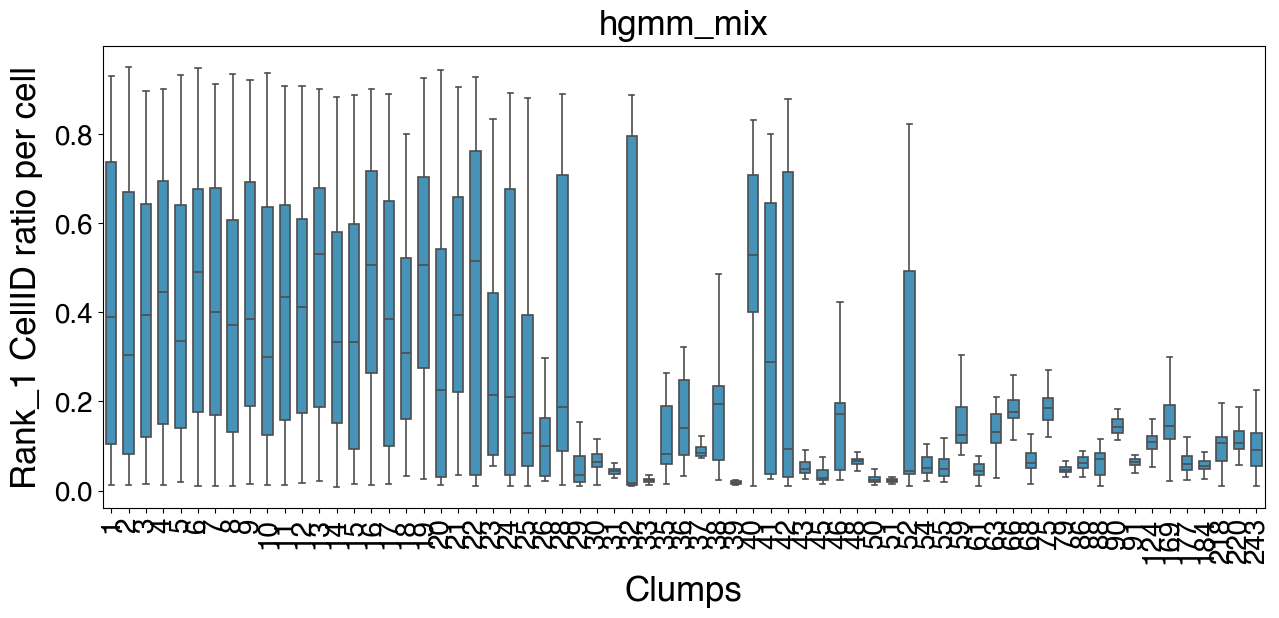

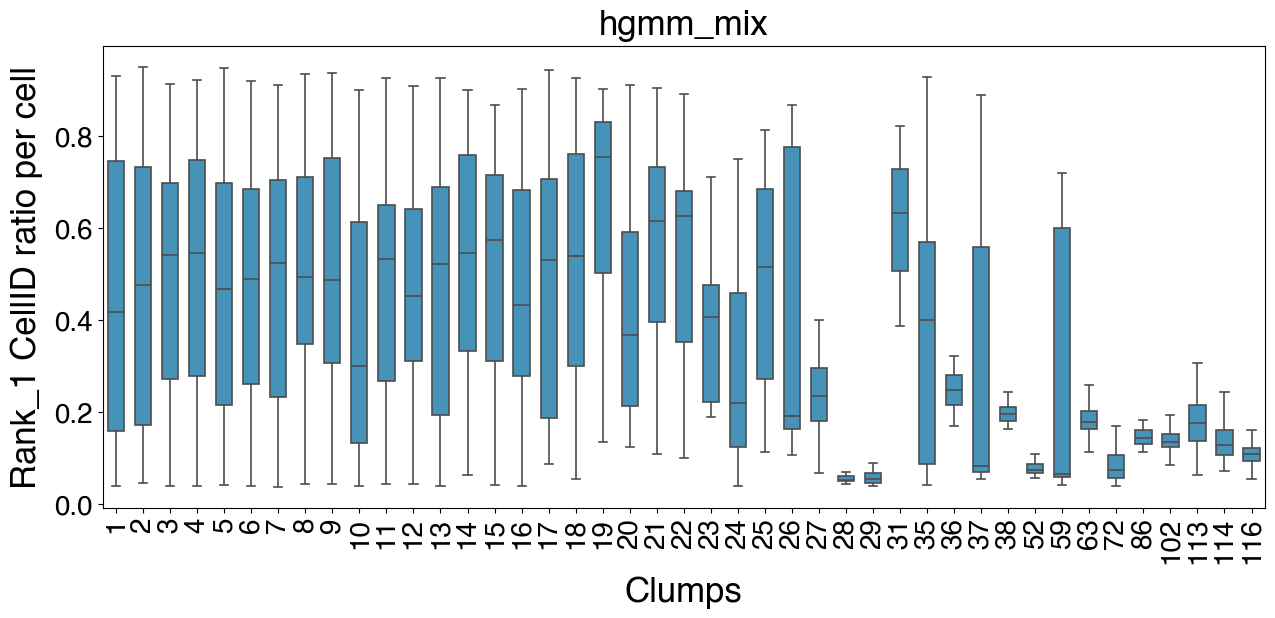

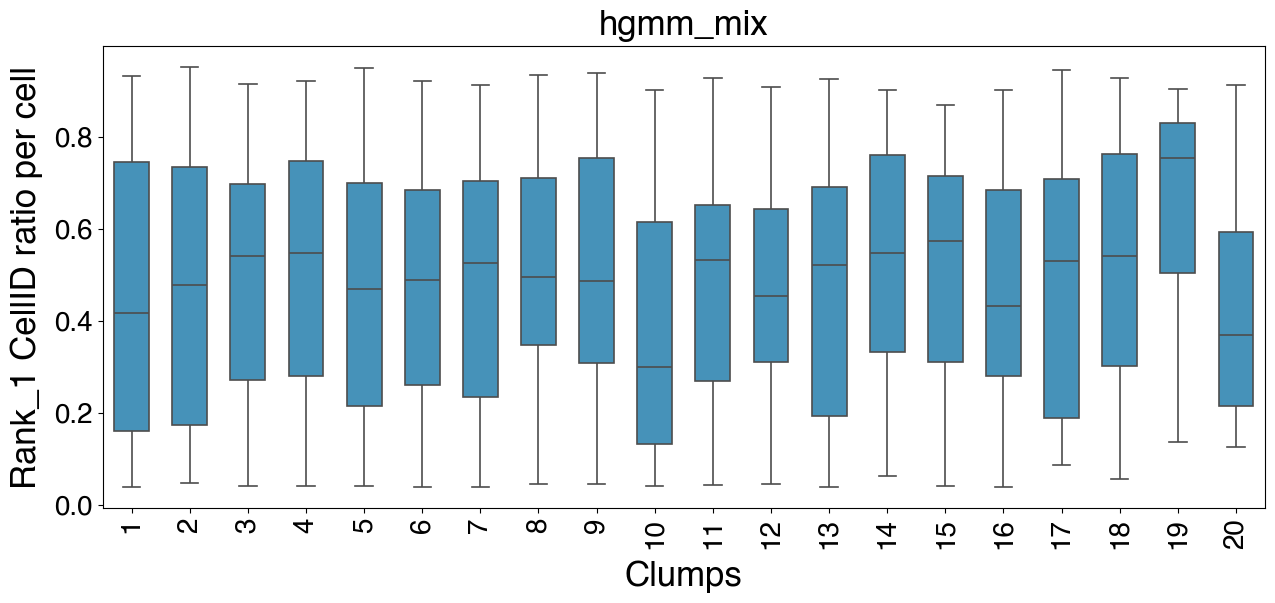

In [61]:
df = pd.read_csv(in_path + 'result_without_qc.txt', sep='\t')
df.columns = ['CellID_Barcode'] + list(df.columns[1:])

df['RNA_Barcode'] = ref.loc[df['CellID_Barcode'].values, 'RNA'].values
df.index = df['RNA_Barcode'].values
_plotrank1ratio(df, title='hgmm_mix', save=False)

noise = pd.read_csv(in_path + 'noise_rank.txt', sep='\t', index_col=0)
noise_ratio = noise.div(noise.sum(axis=1), axis='rows')

rank1_threashold = np.percentile(noise['1'].values, [25, 50, 75])[2]
rank1_ratio_threashold = np.percentile(noise_ratio['1'].values, [25, 50, 75])[2]
    
df['qc'] = '0'
df.loc[(df['rank1']>rank1_threashold)&
       (df['rank1_ratio']>rank1_ratio_threashold)&
       (df['rank1']/df['rank2']>rank1_rank2_ratio_threashold),'qc']='1'

df = pd.concat([adata.obs, df], axis=1).reindex(adata.obs.index)
df['qc'] = df['qc'].fillna('0')
_plotrank1ratio(df.loc[df['qc']=='1'], title='hgmm_mix', save=False)

df_ = df.loc[df['qc']=='1',:]
clump = df_.loc[:, 'CellID'].value_counts().to_frame()
idx = clump[clump['CellID']<=clump_size].index
cells = df_.loc[df_['CellID'].isin(idx)].index
df['qc'] = '0'
df.loc[cells, 'qc'] = '1'
_plotrank1ratio(df.loc[df['qc']=='1'], title='hgmm_mix', save=False)
# df.to_csv(in_path + 'result.txt', sep='\t')

## confusion matrix

In [176]:
df = pd.read_csv(in_path + 'result.txt', sep='\t', index_col=0)
df = df.fillna('unknown')
df = df.loc[df['CellID_Barcode']!='unknown']
df['CellID_species'] = [i[-8:] for i in df['CellID'].values]
df['CellID_clump'] = [i[:-8] for i in df['CellID'].values]

df['species_CellID'] = 'GRCm39'
df.loc[df['CellID_species']=='CAGATAGT','species_CellID']='GRCh38'
df = df.loc[df['total_counts']>=1000,:]

0.05987135081642751

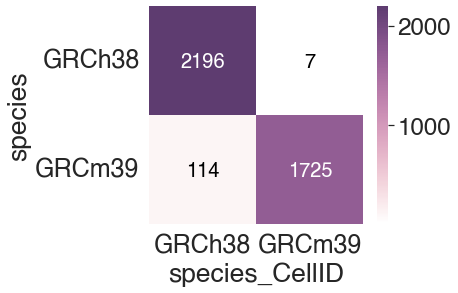

In [179]:
obs = df.loc[df['qc']==1]
obs = obs.loc[obs['species'].isin(['GRCh38','GRCm39']),:]

obs['CellID_species'] = [i[-8:] for i in obs['CellID'].values]
obs['species_CellID'] = 'GRCm39'
obs.loc[obs['CellID_species']=='CAGATAGT','species_CellID']='GRCh38'
data = obs.groupby('species')['species_CellID'].value_counts().unstack()

heatmapPlot(data, 
            figsize=(4.8,4),
            save=False)
2*(data.loc['GRCm39','GRCh38'] + data.loc['GRCh38','GRCm39'])/data.sum().sum()

In [180]:
def InteractionStrength(clumps, cts, method='intensity', weight=False):
    """
    """
    from scipy.special import perm, comb
    out = []
    for clump in clumps:
        df_tmp = pd.DataFrame(index=cts, columns=cts)
        df_tmp = df_tmp.fillna(0)
        tmp = pd.Series(clump).value_counts()
        c = tmp.index
        if method == 'intensity':
            for c1 in c:
                for c2 in c:
                    if tmp.sum()<2:
                        print(clump)
                    if c1 == c2:
                        df_tmp.loc[c1,c2]=comb(tmp[c1],2)/comb(tmp.sum(),2)
                    else:
                        df_tmp.loc[c1,c2]=(tmp[c1]*tmp[c2])/comb(tmp.sum(),2)
            if weight==True:
                out.append(df_tmp*tmp.sum())
            else:
                out.append(df_tmp)
        elif method == 'comb':
            for c1 in c:
                for c2 in c:
                    if c1 == c2:
                        df_tmp.loc[c1,c2]=comb(tmp[c1],2)
                    else:
                        df_tmp.loc[c1,c2]=tmp[c1]*tmp[c2]
            out.append(df_tmp)
        elif method == 'count':
            for i in range(len(clump)):
                for j in range(len(clump)):
                    if i!=j:
                        df_tmp.loc[clump[i],clump[j]]=1
            out.append(df_tmp)
    out = pd.DataFrame(np.sum(out, axis=0), index=cts, columns=cts)
    return out 

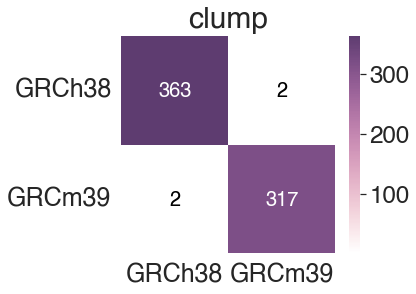

In [181]:
obs = df[df['species'].isin(['GRCm39','GRCh38'])]
obs = obs.loc[obs['species'] == obs['species_CellID']]
obs = obs.loc[obs['qc']==1]

clumps_all = obs.groupby('CellID_clump')['species'].apply(lambda x:list(x))
clumps = []
for clump in clumps_all:
    if len(clump) > 1:
        clumps.append(clump)

s = 0
for clump in clumps:
    tmp = pd.Series(clump).nunique()
    if tmp>1:
        s = s+1

intensity = InteractionStrength(clumps, ['GRCm39','GRCh38'], method='count', weight=False)
intensity = intensity.loc[['GRCh38','GRCm39'],['GRCh38','GRCm39']]
heatmapPlot(intensity, 
            figsize=(4.8,4), 
            # fmt = '%d', 
            title='clump',
            save=False)

## pei plot

In [ ]:
def _peiPlot(data, 
             label,
             title='',
             save=None):
    plt.rc('font', family='Helvetica')
    plt.rcParams['pdf.fonttype'] = 42

    # explode = (0.01,0.1)
    explode = tuple([0.02]*data.shape[0])

    # Creating color parameters
    colors = [(1.0, 0.4980392156862745, 0.054901960784313725),
              (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
              (1.0, 1.0, 0.6),
              '#f9a500',
              (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
              (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
              (0.6941176470588235, 0.34901960784313724, 0.1568627450980392),
              (0.8939638600538254, 0.5441753171856978, 0.7364859669357939),
              '#EDB188',
              '#c8cacc'
             ]

    # Wedge properties
    wp = { 'linewidth' : 0.7, 'edgecolor': "black" ,'width':0.3}

    # Creating autocpt arguments
    def func(pct, allvalues):
        absolute = pct / 100.*np.sum(allvalues)
        return "{:.1f}%\n({:.0f})".format(pct, absolute)

    # Creating plot
    fig, ax = plt.subplots(figsize =(10, 10))
    wedges, texts, autotexts = ax.pie(data,
                                      radius=0.7, 
                                      autopct = lambda pct: func(pct, data),
                                      explode = explode, 
                                      labels = label,
                                      # shadow = True,
                                      colors = colors,
                                      startangle = 90,
                                      wedgeprops = wp,
                                      textprops = {'fontsize': 20}
                                     )

    ax.legend(wedges, label,
              title ="The number of cells per clump",
              loc="center left",
              bbox_to_anchor=(0.95, 0, 0.5, 1),
              fontsize=18,
              title_fontsize=20,
             )

    plt.setp(autotexts, size = 15, weight ="bold")
    ax.set_title(title, fontsize=20, va='center',pad=1,)
    if save:
        plt.savefig(save, bbox_inches='tight')

In [190]:
df = pd.read_csv(in_path + 'result.txt', sep='\t', index_col=0)
df = df.fillna('unknown')
df = df.loc[df['CellID_Barcode']!='unknown']
df['CellID_species'] = [i[-8:] for i in df['CellID'].values]
df['CellID_clump'] = [i[:-8] for i in df['CellID'].values]

df['species_CellID'] = 'GRCm39'
df.loc[df['CellID_species']=='CAGATAGT','species_CellID']='GRCh38'
df = df.loc[df['total_counts']>=1000,:]


df = df.loc[df['qc']==1]
df = df.loc[df['species'].isin(['GRCh38','GRCm39']),:]

clump = df['CellID_clump'].value_counts().to_frame()
clump[clump>10] = 10
clump_counts = clump['CellID_clump'].value_counts()
clump_counts = clump_counts.reindex([1,2,3,4,5,6,7,8,9,10])
cell_counts = pd.Series(clump_counts.index * clump_counts.values, index=clump_counts.index)
cell_counts[10] = df.shape[0] - cell_counts.sum()+cell_counts[10]

/tmp/ipykernel_173787/1009569804.py:6: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  title='n={}'.format(str(cell_counts[1:].sum())),


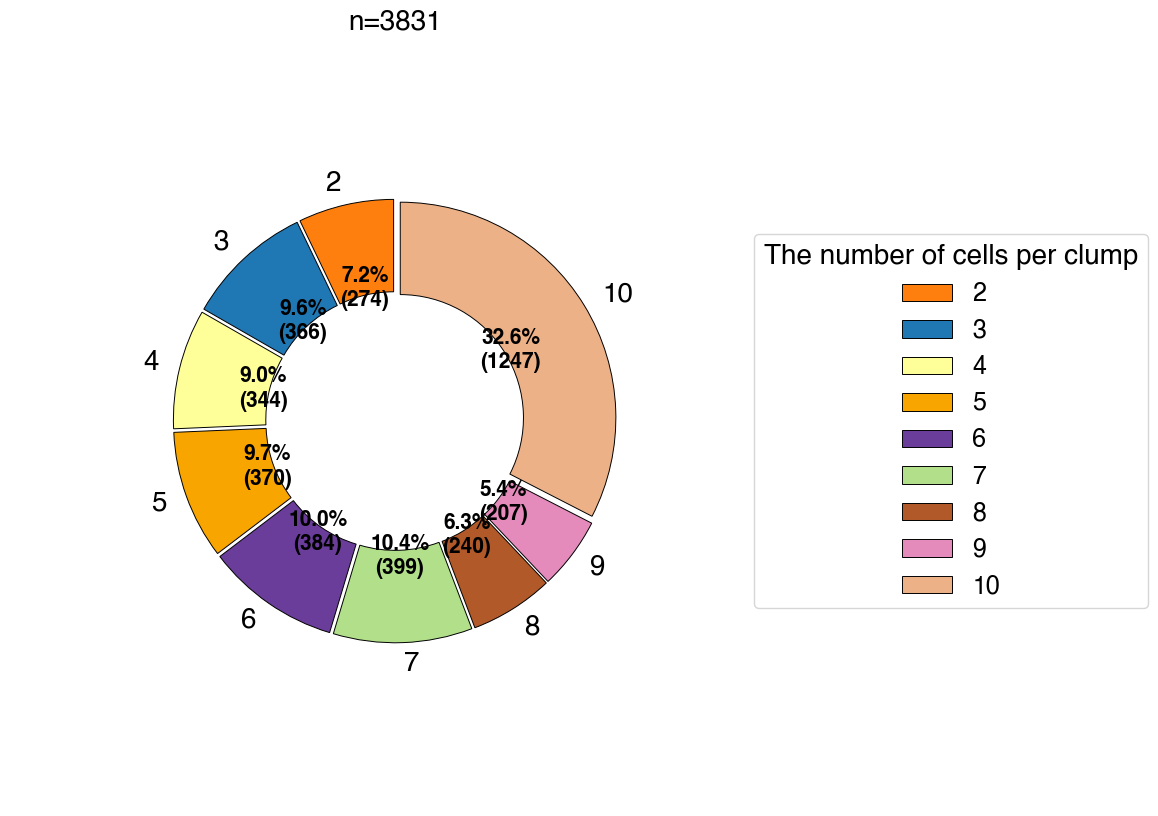

In [195]:
plt.style.use('default')
plt.rc('font', family='Helvetica')
plt.rcParams['pdf.fonttype'] = 42

_peiPlot(data=cell_counts.values[1:], 
     label=cell_counts.index[1:],
     title='n={}'.format(str(cell_counts[1:].sum())),
     save=False)

## after CellID quality control

In [166]:
df_signal = pd.read_csv(in_path+'signal_rank.txt', sep='\t', index_col=0)
df_noise = pd.read_csv(in_path+'noise_rank.txt', sep='\t', index_col=0)

df = pd.read_csv(in_path+ 'result.txt', sep='\t', index_col=0)
df = df.fillna('unknown')
df = df.loc[df['CellID_Barcode']!='unknown']
df = df.loc[df['species'].isin(['GRCh38','GRCm39']),:]
df = df.loc[df['total_counts']>=1000,:]
df = df.loc[df['qc']==1]

df_signal = df_signal.loc[df['CellID_Barcode'].values,:]

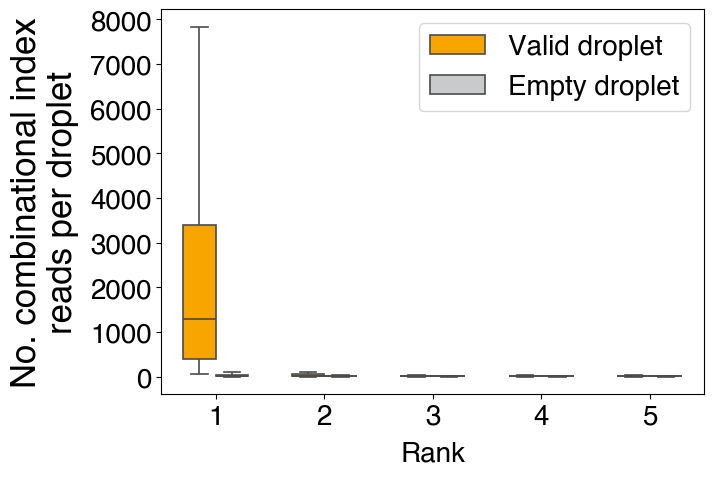

In [167]:
out = pd.DataFrame({'CellID': list(df_signal.iloc[:,:5].values.reshape(-1,))+list(df_noise.iloc[:,:5].values.reshape(-1,)),
                    'Rank':list([1,2,3,4,5])*df_signal.shape[0]+list([1,2,3,4,5])*df_noise.shape[0],
                    'Class':['Valid droplet']*(df_signal.shape[0]*5) + ['Empty droplet']*(df_noise.shape[0]*5)})

plt.figure(figsize=(7,5))
sns.boxplot(x="Rank", 
            y="CellID", 
            data=out, 
            hue='Class', 
            linewidth=1.2, 
            fliersize=0.8, 
            width=0.6,
            showfliers=False, 
            saturation=1, 
            palette=['#f9a500', '#c8cacc'])

plt.xticks(rotation=0, fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('No. combinational index\nreads per droplet',fontsize=25,labelpad=8)
plt.xlabel('Rank',fontsize=20,labelpad=8)
plt.title('',fontsize=25, pad=8)
plt.legend(loc='best',fontsize=20)

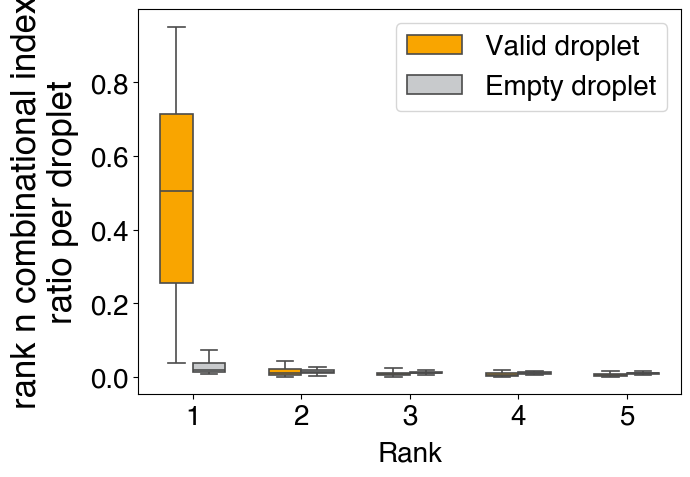

In [168]:
df_signal_ratio = df_signal.div(df_signal.sum(axis=1), axis='rows')
df_noise_ratio = df_noise.div(df_noise.sum(axis=1), axis='rows')

out = pd.DataFrame({'CellID': list(df_signal_ratio.iloc[:,:5].values.reshape(-1,))+list(df_noise_ratio.iloc[:,:5].values.reshape(-1,)),
                    'Rank':list([1,2,3,4,5])*df_signal_ratio.shape[0]+list([1,2,3,4,5])*df_noise_ratio.shape[0],
                    'Class':['Valid droplet']*(df_signal_ratio.shape[0]*5) + ['Empty droplet']*(df_noise_ratio.shape[0]*5)})

plt.figure(figsize=(7,5))
sns.boxplot(x="Rank", 
            y="CellID", 
            data=out, 
            hue='Class', 
            linewidth=1.2, 
            fliersize=0.8, 
            width=0.6,
            showfliers=False, 
            saturation=1, 
            palette=['#f9a500', '#c8cacc'])

plt.xticks(rotation=0, fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('rank n combinational index\nratio per droplet',fontsize=25,labelpad=8)
plt.xlabel('Rank',fontsize=20,labelpad=8)
plt.title('',fontsize=25, pad=8)
plt.legend(loc='best',fontsize=20)

In [170]:
d1 = df_signal.sum(axis=1).astype(int)
d2 = df_noise.sum(axis=1).astype(int)
d1 = pd.DataFrame(d1)
d2 = pd.DataFrame(d2)
d1.columns = ['CellID']
d2.columns = ['CellID']
d1['Class'] = 'Valid\ndroplet'
d2['Class'] = 'Empty\ndroplet'

out = pd.concat([d1,d2])

/tmp/ipykernel_173787/1420286809.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Class",


Text(0.5, 1.0, '')

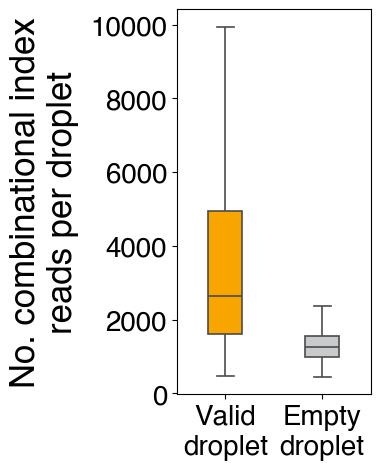

In [171]:
plt.figure(figsize=(2.5,5))
sns.boxplot(x="Class", 
            y="CellID", 
            data=out, 
            linewidth=1.2, 
            fliersize=0.8, 
            width=0.35,
            showfliers=False, 
            saturation=1,
            palette=['#f9a500', '#c8cacc'])

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('No. combinational index\nreads per droplet',fontsize=25,labelpad=8)
plt.xlabel('',fontsize=20,labelpad=8)
plt.title('',fontsize=25, pad=8)

In [172]:
a = out.loc[out.Class=='Valid\ndroplet','CellID'].values
b = out.loc[out.Class!='Valid\ndroplet','CellID'].values

print('Performing t-test analysis...')
from scipy.stats import ttest_ind
from scipy.stats import levene

stat, p = levene(a,b)

if p < 0.05:
    f, p = ttest_ind(a,b, alternative='greater', equal_var=False)
else:
    f, p = ttest_ind(a,b, alternative='greater', equal_var=True)
    
from pprint import pprint
pprint((ttest_ind(a,b, alternative='greater', equal_var=False)[0],
        ttest_ind(a,b, alternative='greater', equal_var=False)[1]))

p = ttest_ind(a,b, alternative='greater', equal_var=False)[1]

Performing t-test analysis...
(40.024683994874145, 1.0055108397820432e-295)


In [173]:
tmp1 = df_signal.iloc[:,:2]
tmp2 = df_noise.iloc[:,:2]
tmp1['Class'] = 'Valid\ndroplet'
tmp2['Class'] = 'Empty\ndroplet'
out = pd.concat([tmp1, tmp2])
out['CellID'] = out['1']/out['2']

/tmp/ipykernel_173787/1538100658.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['Class'] = 'Valid\ndroplet'
/tmp/ipykernel_173787/1538100658.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp2['Class'] = 'Empty\ndroplet'


/tmp/ipykernel_173787/2220622364.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Class",


Text(0.5, 1.0, '')

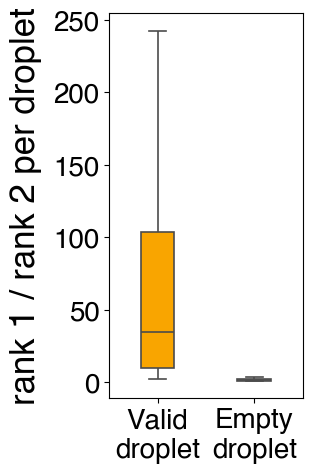

In [174]:
plt.figure(figsize=(2.5,5))
sns.boxplot(x="Class", 
            y="CellID", 
            data=out, 
            linewidth=1.2, 
            fliersize=0.8, 
            width=0.35,
            showfliers=False, 
            saturation=1,
            palette=['#f9a500', '#c8cacc'])

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('rank 1 / rank 2 per droplet',fontsize=25,labelpad=8)
plt.xlabel('',fontsize=20,labelpad=8)
plt.title('',fontsize=25, pad=8)

In [175]:
a = out.loc[out.Class=='Valid\ndroplet','CellID'].values
b = out.loc[out.Class!='Valid\ndroplet','CellID'].values

print('Performing t-test analysis...')
from scipy.stats import ttest_ind
from scipy.stats import levene

stat, p = levene(a,b)

if p < 0.05:
    f, p = ttest_ind(a,b, alternative='greater', equal_var=False)
else:
    f, p = ttest_ind(a,b, alternative='greater', equal_var=True)
    
from pprint import pprint
pprint((ttest_ind(a,b, alternative='greater', equal_var=False)[0],
        ttest_ind(a,b, alternative='greater', equal_var=False)[1]))

Performing t-test analysis...
(39.17101876980767, 4.184516812399106e-285)


## dotplot

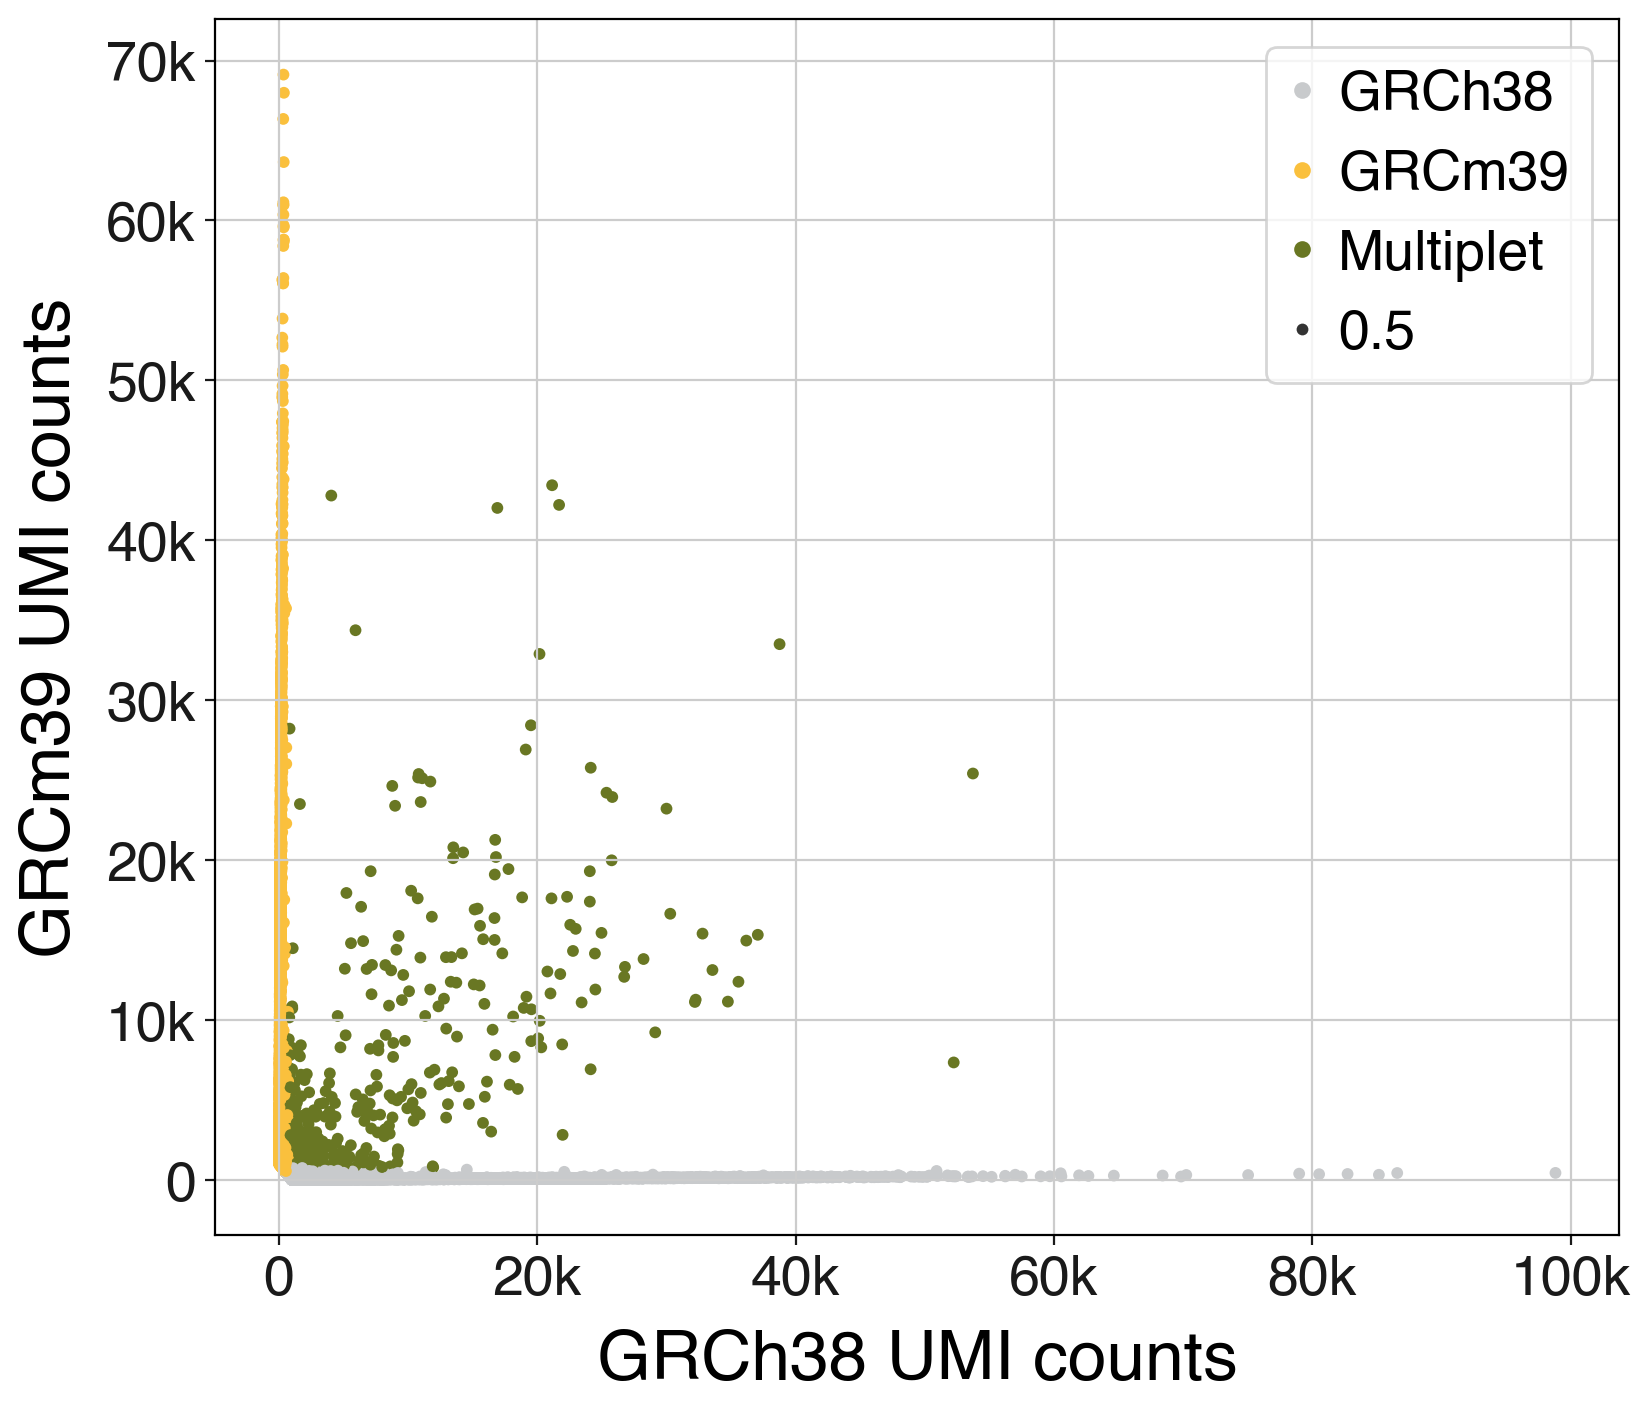

In [196]:
df = pd.read_csv('/home/tiankang/tanglei/submit/processed/Fig.1/result.txt', sep='\t', index_col=0)
df = df.fillna('unknown')
df = df.loc[df['CellID_Barcode']!='unknown']
df = df.loc[df['total_counts']>=1000,:]

plt.style.use('default')
plt.rc('font', family='Helvetica')
plt.rcParams['pdf.fonttype'] = 42

sc.set_figure_params(dpi=100, figsize=(8,8), fontsize=20)
plt.figure(figsize=(9,8))
sns.scatterplot(data=df,
                x="total_counts_hg38", 
                y="total_counts_mm10", 
                size=0.5,
                linewidth=0,
                hue='species',
                hue_order=['GRCh38','GRCm39','Multiplet'],
                palette=['#c8cacc','#fac03d','#697723', ])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('GRCm39 UMI counts',fontsize=25,labelpad=8)
plt.xlabel('GRCh38 UMI counts',fontsize=25,labelpad=8)
plt.xticks([0,20000,40000,60000,80000,100000],['0','20k','40k','60k','80k','100k'])
plt.yticks([0,10000,20000,30000,40000,50000,60000,70000],['0','10k','20k','30k','40k','50k','60k','70k'])

plt.title('',fontsize=25, pad=8)
plt.legend(loc='best',fontsize=20)